# Sentiment Classification of Product Reviews

The libraries used in the project are:
* pandas(for dataframe manipulation) 
* nltk (for text pre-processing)
* numpy (for calculating statistics)
* sklearn (for implementing machine learning algorithms)
* matplotlib (for creating data visualisations)

## 1. Introduction

The objective of the task was to develop a sentiment classifer using a dataset that contains 650k yelp reviews. The dataset has sentiment labels varying from level 1 to level 5 with level 1 being strong negative to level 5 being strong positive and level 3 being neutral. Text preprocessing was done on the yelp reviews, followed by feature extraction to convert the text to a numerical representation that can be used in statistical models. Statistical models were then used to develop a classifer to predict the sentiment label of the yelp reviews in the testing dataset.

Several preprocessing steps including case normalization, removing non alpha-numeric words, removing stop words, stemming and lemmatization were attempted. Removing stop words decreased the accuracy of the statistical models. Stemming and lemmatization did not improve the prediction accuracy and were taking too much time for computation. Hence, the final preprocessing steps done for the yelp reviews were case normalization and removing non-alphanumeric words. 

Unigram and Bigram features were extracted from the reviews. Term Frequency (TF) and Term Frequency Inverse Document Frequency (TF-IDF) representations were attempted; TF-IDF representation yielded a slightly higher accuracy in the statistical models.The number of features used in the final classifer were 10,000; this was finalised after experimenting with different number of features.  

Several statistical models including multinomial Naive Bayes, Multinomial Logistic Regression and Linear Support Vector Classifier were used to develop the sentiment classifer. Multinomial Logistic Regression was found to have the highest predictive power for this dataset and used in the final classifer.

## 2. Loading libraries and Data

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import nltk 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# Reading training data
train = pd.read_csv('train_data.csv', index_col = 0)
train_label = pd.read_csv('train_label.csv', index_col = 0)

In [3]:
# check that training data loaded correctly
print(train.head())
print(train_label.head())

                                                     text
trn_id                                                   
trn_1   Well this place got me to write my first revie...
trn_2   A very good Greek restaurant with tasty food. ...
trn_3   Website says open, Google says open, Yelp says...
trn_4   If I could give zero stars I would. When we wa...
trn_5   They have great food & definitely excellent se...
        label
trn_id       
trn_1       2
trn_2       5
trn_3       1
trn_4       1
trn_5       5


In [4]:
# reading testing data
test = pd.read_csv('test_data.csv',index_col = 0)
test.head() # check

,text
test_id,
test_1,trying to have a nice quiet dinner. the annou...
test_2,Been getting food to go from here for over 3yr...
test_3,Ugh. I've had to eat here a couple of times be...
test_4,The people here are so nice! I ordered on eat ...
test_5,Heard alot of good things about this place and...


In [5]:
# check distribution of labels
train_label.label.value_counts()

5    130000
4    130000
3    130000
2    130000
1    130000
Name: label, dtype: int64

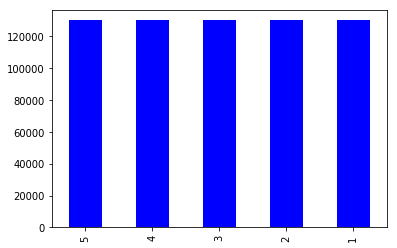

In [6]:
train_label.label.value_counts().plot(kind = 'bar', color = 'b')

The classes of sentiment labels are equally balanced. No class imbalance

## 3. Preprocessing

In [7]:
# functions for tokenization with case normalisation to lower case   
def tokenize(text):
    tokens = nltk.tokenize.word_tokenize(text.lower())
    return tokens

In [8]:
# function for removing non alpha-numeric tokens and stopword tokens
def removeNonAlphaNum(l):
    return [token for token in l if token.isalpha()]


def removeStopwords(l, custom_stop_words):
    return [word for word in l if word not in custom_stop_words]

In [9]:
# functions for stemming and lemmatizing tokens
lemmatizer = WordNetLemmatizer()
def lemmatize(l):
    return [lemmatizer.lemmatize(token) for token in l]

stemmer = PorterStemmer()
def stem(l):
    return [stemmer.stem(token) for token in l]

In [10]:
# final function for preprocessing tokens: only case normalization and removing non-alphanumeric tokens done 
def preprocess(l):
    return removeNonAlphaNum(l)

In [11]:
# function for joining the tokens to get a cleaned yelp review
def cleanString(l):
    return ' '.join(l)

In [12]:
# preprocessing training data using functions defined above
train['text'] = train['text'].apply(tokenize)
train['text'] = train['text'].apply(preprocess)
train['text'] = train['text'].apply(cleanString)

In [13]:
train['text'].head(1) # check

trn_id
trn_1    well this place got me to write my first revie...
Name: text, dtype: object

#### Exploratory Analysis of Reviews

Let's find the average length and standard deviation of the preprocessed tokens:

In [14]:
def size(text):
    return len(text)
train['lengths'] = train['text'].apply(size)
train['lengths'].describe() # summary stats of length of reviews

count    650000.000000
mean        623.372735
std         568.326569
min           0.000000
25%         249.000000
50%         452.000000
75%         800.000000
max        4919.000000
Name: lengths, dtype: float64

In [15]:
# dropping reviews with 0 tokens
drop_idx = train.loc[train['lengths'] == 0,].index
train.drop(drop_idx, axis=0,inplace=True)
train_label.drop(drop_idx, axis=0,inplace=True)
print(train.shape, train_label.shape)

(649916, 2) (649916, 1)


In [16]:
train['lengths'].describe() # summary stats of length of reviews

count    649916.000000
mean        623.453305
std         568.319104
min           1.000000
25%         249.000000
50%         452.000000
75%         800.000000
max        4919.000000
Name: lengths, dtype: float64

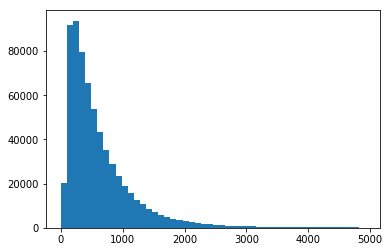

In [17]:
# histogram of length of reviews
plt.hist(train['lengths'], bins = 50)
plt.show()

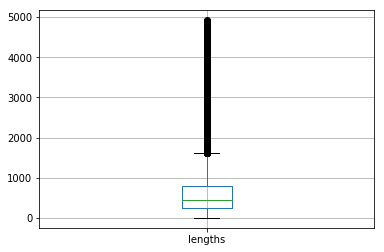

In [18]:
# boxplot of length of reviews
train.boxplot(column='lengths')

Finding the number of tokens and the size of vocabulary:

In [19]:
# number of tokens in data
number_of_tokens = train['text'].apply(lambda x: len(x.split(' '))).sum()
number_of_tokens

78360509

In [20]:
# compute the size of vocab
train_countvec = CountVectorizer(analyzer = "word", ngram_range = (1,1))
train_tf = train_countvec.fit_transform(train['text'])
train_tf.shape[1]

173810

In [21]:
print ("Vocabulary size: ",train_tf.shape[1],"\nTotal number of tokens: ", number_of_tokens)

Vocabulary size:  173810 
Total number of tokens:  78360509


We have around 80 million tokens in the data and the size of vocab is around 174k

## 4. Feature Extraction

#### Splitting training data

Before feature extraction, let us split the training data into training set and validation set so that we can validate the trained classifer. Splitting is done before feature extraction because we do not want to use the validation set to extract any features replicating the scenario for unseen testing data.

As we have 650k records, we can go with a 95:5 split and have a sizable number of records (more than 30k records) in the validation set. 

*Note that 84 records with only special symbols were removed for training the classifer.*

In [22]:
# split train data into training set and validation set
train_set = train.sample(frac = 0.95,random_state = 10) #95:5 split
validation_set = train.drop(train_set.index)
print('No. of rows in train_set:', len(train_set))
print('No. of rows in validation_set:', len(validation_set))

No. of rows in train_set: 617420
No. of rows in validation_set: 32496


#### TF-IDF Vectorization

Converting raw text to TF-IDF numerical representation by extracting unigram and bigram features from the text. 
The number of features extracted in the final classifer is 10,000

In [23]:
# tf-idf vectors of training set
train_tfidf = TfidfVectorizer(analyzer = "word", ngram_range = (1,2),max_features = 10000)
X_train = train_tfidf.fit_transform(train_set['text'])
X_train.shape

(617420, 10000)

In [24]:
# Converting labels of reviews in training set to a numpy array for sklearn model
Y_train = np.ravel(train_label.loc[train_set.index])

## 5. Modelling

Training a logistic regression classifer and testing it on the validation set:

In [25]:
# Logit model using saga solver as it scales better for large datasets according to sklearn document # reference 1
logit = LogisticRegression(random_state = 10, solver = 'saga',multi_class = 'multinomial').fit(X_train, Y_train)

In [26]:
# TF-IDF vectorization of validation set
X_validation = train_tfidf.transform(validation_set['text'])
# prediction on validation set
Y_predict = logit.predict(X_validation)

In [27]:
# printing accuracy score and classification report of predictions on validation set
Y_true = np.array(train_label.loc[validation_set.index])
accuracy = accuracy_score(Y_true, Y_predict)
print('Accuracy of validation set is', accuracy)
print(classification_report(Y_true, Y_predict))

Accuracy of validation set is 0.6418020679468243
             precision    recall  f1-score   support

          1       0.73      0.78      0.76      6425
          2       0.57      0.56      0.57      6553
          3       0.56      0.53      0.54      6529
          4       0.57      0.58      0.58      6353
          5       0.76      0.75      0.75      6636

avg / total       0.64      0.64      0.64     32496



From the detailed classification report, we can see that the classifer is better at predicting strong negative and strong positive sentiments compared to the neutral and weaker sentiments

## 6. Prediction on test data

Final model by training the model on the complete data set:

In [28]:
# tf-idf vectors for entire training data
train_tfidf_complete = TfidfVectorizer(analyzer = "word", ngram_range = (1,2),max_features = 10000)
X_train_complete = train_tfidf_complete.fit_transform(train['text'])

In [29]:
# training logit model on entire data
Y_train_complete = np.ravel(train_label)
logit_complete = LogisticRegression(random_state = 10, solver = 'saga',multi_class = 'multinomial').fit(
                                                                                        X_train_complete, Y_train_complete)

Predicting sentiment labels of the reviews in test data using the final model:

In [30]:
# preprocessing test set
test['text'] = test['text'].apply(tokenize)
test['text'] = test['text'].apply(preprocess)
test['text'] = test['text'].apply(cleanString)
test['text'].head(1)

test_id
test_1    trying to have a nice quiet dinner the announc...
Name: text, dtype: object

In [31]:
# prediction on test set
X_test = train_tfidf_complete.transform(test['text'])
test['label'] = logit_complete.predict(X_test)

In [32]:
# writing predictions to a file
test_out = test.drop(columns = 'text')
test_out.to_csv('predict_label.csv')

## References  
1. Scikit learn. *Generalized linear models: 1.1.11 Logistic Regression*. Retrieved from https://scikit-learn.org/stable/modules/linear_model.html